In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from train import test1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()
import seaborn as sns

import os
import cv2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!del /Q /S /F runs\*
#!rmdir /S /Q runs

In [4]:
torch.cuda.is_available(), torch.version.cuda

(True, '11.7')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip install https://download.pytorch.org/whl/nightly/cu117/torch-1.14.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/nightly/cu117/torchvision-0.15.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
torch.cuda.is_available(), torch.version.cuda

In [6]:
DATA_PATH = '/home/ddavilag/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/ddavilag/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

cols= ['unique_key', 'bnpp_value_log', 'BNP_value' 
        #'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime'
       ]
test_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv', usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan','ddavilag')
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan','ddavilag')
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan','ddavilag')
new_valid = pd.concat([test_df,val_df],ignore_index=False)
train_df.shape, test_df.shape, val_df.shape,new_valid.shape

train_df.reset_index(names='unique_key',inplace=True)
val_df.reset_index(names='unique_key',inplace=True)
test_df.reset_index(names='unique_key',inplace=True)
new_valid.reset_index(names='unique_key',inplace=True)

train_df = train_df.to_numpy()
new_valid = new_valid.to_numpy()
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()

In [13]:
#from zmq import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df[idx,:]
        #plt.imshow(im,cmap='gray')
        #plt.show()
        #returns image, bnpp value log, binary variable for edema
        return torch.load(row[4]).view(1, 224, 224).expand(3, -1, -1), row[1], row[3]
        #return torch.load(row[4]).view(1, 224, 224), row[1], row[3]

In [14]:
batch_size = 16 #maybe change to 16, 8
num_workers = 2
pin_memory = True
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = PreprocessedImageDataset(df=train_df) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = PreprocessedImageDataset(df=val_df) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

#print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))
#len(valid_set)
test_set = PreprocessedImageDataset(df=test_df)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

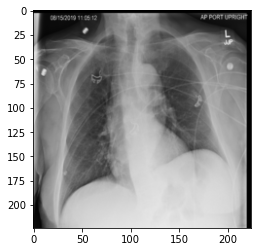

In [17]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray')

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = 'ResNet'
if model == 'VGG16':
    model = VGG('VGG16').to(device)
elif model == 'ResNet':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model.to(device)
model

cuda


Using cache found in /home/ddavilag/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys_r")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, _ = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 58,145,857 total parameters.
[INFO]: 58,145,857 trainable parameters.


In [20]:
os.environ['NUM_GPU']='1'

In [21]:

# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 25
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses = np.array([]),np.array([])
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

#     for param in model.parameters():
#         param.requires_grad = True
    #avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    for param in model.parameters():
        param.requires_grad = True
    avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    
    
#     for param in model.parameters():
#         param.requires_grad = False
#     with torch.no_grad():
#         avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)
    for param in model.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
    np.append(tlosses,avg_tloss)
    np.append(vlosses,avg_vloss)

    epoch_number += 1
    scheduler.step(avg_vloss)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
#writer.flush()
#writer.close()

EPOCH 1:


100%|██████████| 120/120 [00:07<00:00, 15.93it/s]

LOSS train 0.605619807744056 valid 0.5395232569109661
EPOCH 2:



 10%|█         | 95/948 [00:23<03:32,  4.02it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
 10%|█         | 96/948 [00:24<03:31,  4.02it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.4758180846347564 valid 0.49271415582979955
EPOCH 3:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  7%|▋         | 67/948 [00:17<03:36,  4.07it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUD

LOSS train 0.4176454250194494 valid 0.48690442618915797
EPOCH 4:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.37378071373616434 valid 0.5337933261945511
EPOCH 5:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.33191053907123463 valid 0.48621246945503616
EPOCH 6:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 1/948 [00:00<05:26,  2.90it/s]/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered

LOSS train 0.2986208058617508 valid 0.48649098156639364
EPOCH 7:



  0%|          | 0/948 [00:00<?, ?it/s]/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (func

LOSS train 0.2760548413276536 valid 0.4858648009716582
EPOCH 8:



100%|██████████| 120/120 [00:07<00:00, 15.82it/s]

LOSS train 0.2603157261298999 valid 0.495577266939753
EPOCH 9:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.24339427028677918 valid 0.5585591475615329
EPOCH 10:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.23211451459440882 valid 0.479859984275281
EPOCH 11:



  0%|          | 0/948 [00:00<?, ?it/s]/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (func

LOSS train 0.21962958308551894 valid 0.4750143584948667
EPOCH 12:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.20867511066936995 valid 0.47771781923908513
EPOCH 13:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 1/948 [00:00<05:15,  3.00it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: 

LOSS train 0.20168648419327148 valid 0.48156025551221204
EPOCH 14:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.19348048694808198 valid 0.4689990274014563
EPOCH 15:



  5%|▌         | 52/948 [00:13<03:45,  3.97it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (

LOSS train 0.18361155267968188 valid 0.47145447419590025
EPOCH 16:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 1/948 [00:00<05:21,  2.94it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 2/948 [00:00<04:31,  3.48it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function unche

LOSS train 0.18142069947083198 valid 0.48065308963163794
EPOCH 17:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 1/948 [00:00<05:03,  3.12it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: 

LOSS train 0.17548285557547855 valid 0.47855900549078145
EPOCH 18:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function un

LOSS train 0.17224815699740068 valid 0.47223724126699823
EPOCH 19:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.1646001090791349 valid 0.46580212911912555
EPOCH 20:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.15792198196058407 valid 0.46833071704435614
EPOCH 21:



  0%|          | 0/948 [00:00<?, ?it/s]/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (func

LOSS train 0.15435477887060348 valid 0.46628187400810606
EPOCH 22:



 12%|█▏        | 110/948 [00:27<03:31,  3.96it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
 12%|█▏        | 111/948 [00:27<03:30,  3.97it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:6

LOSS train 0.15119883895325856 valid 0.4602691127703253
EPOCH 23:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 1/948 [00:00<05:18,  2.97it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 2/948 [00:00<04:33,  3.46it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function unche

LOSS train 0.14587020762824016 valid 0.4569911459445629
EPOCH 24:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.14372755496280543 valid 0.4613692016771479
EPOCH 25:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  0%|          | 1/948 [00:00<04:56,  3.19it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: 

LOSS train 0.1386614725420231 valid 0.46766365332286786


In [22]:
#loss on unseen test set
for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model, loss_fn, test_loader)
print(test_loss)

  7%|▋         | 132/1823 [00:04<00:56, 30.06it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal 

0.47213289888407156


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


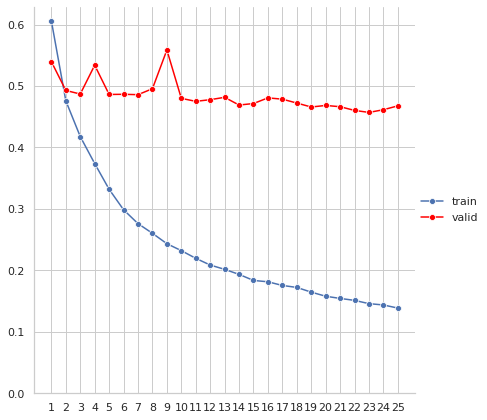

In [23]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

In [24]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model(image)
            hearts = np.append(hearts, heart)
            #preds = np.append(preds, pred.item())
            preds = np.append(preds, pred.cpu())

100%|██████████| 1823/1823 [00:59<00:00, 30.43it/s]


In [25]:
preds

array([2.48980069, 2.56113648, 2.36790872, ..., 2.01263452, 1.96860802,
       3.11139417])

In [26]:
prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()

In [27]:
np.power(10,np.log10(400))/(np.power(10,preds)).sum()

8.106376143754693e-05

In [28]:
y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())
y_preds.sum()

1257

In [29]:
hearts

array([1., 0., 1., ..., 0., 1., 1.])

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts, y_preds,normalize='true')
print(cf_mat_norm)

accuracy score: 0.7827756445419638

TN: 434
FP: 264
FN: 132
TP: 993

Confusion matrix
[[434 264]
 [132 993]]

[[0.6217765  0.3782235 ]
 [0.11733333 0.88266667]]


In [31]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model 1 AUC score: 0.7522215854823304


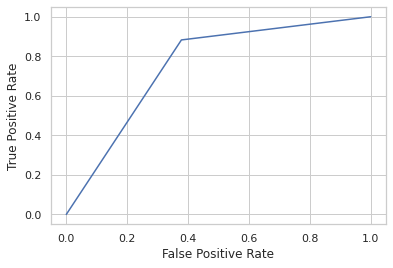

In [32]:
plot_roc_curve(hearts, y_preds)
print(f'model 1 AUC score: {roc_auc_score(hearts, y_preds)}')

model 1 AUC score: 0.8699382362304998


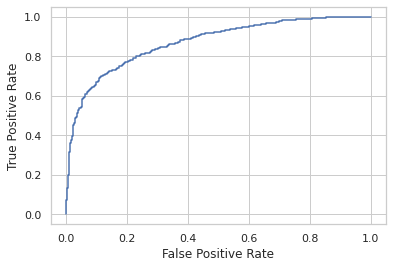

In [33]:
plot_roc_curve(hearts, preds)
print(f'model 1 AUC score: {roc_auc_score(hearts, prob_preds)}')

torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()